# Project4 - Deep Lerning

## Image Classification


---
## 데이터 설명 - Stanford Cars Dataset (1.85 GB)

http://ai.stanford.edu/~jkrause/cars/car_dataset.html

196 class의 (차종)

8,144 개의 train 이미지 

8,041 개의 test 이미지

총 16,185 개의 이미지로 구성


* 

주어진 데이터는 바운딩 박스의 좌표 데이터도 함께 주어졌다. 따라서 전처리로 선행되어야 할 바운딩 처리는 생략하고 진행한다.

---

##Data set 정보
- train.csv - Train 셋의 이미지 파일명, 바운딩박스 좌표, 차종정보
- test.csv - Test 셋의 이미지 파일명, 바운딩박스 좌표, 차종정보
- class.csv - 데이터 셋의 class 컬럼과 대응되는 차종의 레이블
- train - Train 이미지 파일
- test - Test 이미지 파일

---

## 목표 

1. 이미지에서 자동차 인식

2. 구분된 자동차의 차종 분류 예측  
   (test 의 class 가 target이 된다.)

---


In [68]:
import os
import gc
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## 드라이브 마운트

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## 파일 로드 및 확인

In [3]:
DATA_PATH = '/content/drive/My Drive/Colab Notebooks/Stanford Cars Dataset/car_data/car_data/'
os.listdir(DATA_PATH)

['train.csv', 'test', 'class.csv', 'test.csv', 'train']

In [4]:
# 이미지 폴더 경로
TRAIN_IMG_PATH = os.path.join(DATA_PATH, 'train')
TEST_IMG_PATH = os.path.join(DATA_PATH, 'test')

# CSV 파일 경로
df_train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
df_test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
df_class = pd.read_csv(os.path.join(DATA_PATH, 'class.csv'))

In [5]:
df_train.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
0,00001.jpg,39,116,569,375,14
1,00002.jpg,36,116,868,587,3
2,00003.jpg,85,109,601,381,91
3,00004.jpg,621,393,1484,1096,134
4,00005.jpg,14,36,133,99,106


In [6]:
df_test.head()

,img_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2
0,00001.jpg,30,52,246,147
1,00002.jpg,100,19,576,203
2,00003.jpg,51,105,968,659
3,00004.jpg,67,84,581,407
4,00005.jpg,140,151,593,339


In [7]:
df_class.head()

,id,name
0,1,AM General Hummer SUV 2000
1,2,Acura RL Sedan 2012
2,3,Acura TL Sedan 2012
3,4,Acura TL Type-S 2008
4,5,Acura TSX Sedan 2012


In [8]:
df_class[df_class['id'] == 32]

,id,name
31,32,BMW X5 SUV 2007


In [9]:
# Data 누락 체크
if set(list(df_train.img_file)) == set(os.listdir(TRAIN_IMG_PATH)) :
    print("Train file 누락 없음!")
else : 
    print("Train file 누락")

if set(list(df_test.img_file)) == set(os.listdir(TEST_IMG_PATH)) :
    print("Test file 누락 없음!")
else : 
    print("Test file 누락")

Train file 누락 없음!
Test file 누락 없음!


## 파일 실제 확인

In [10]:
## 파일 총 길이 체크 (test = 8041)
len(os.listdir(TEST_IMG_PATH))

8041

In [11]:
## 파일 총 길이 체크 (train = 8144)
len(os.listdir(TRAIN_IMG_PATH))

8144

In [12]:
## class 종류 
len(df_class)

196

In [13]:
## train 파일의 class 종류 
df_train['class'].nunique()

196

In [16]:
# ## 파일 업로드 오류 찾기 (test)
# a1 = os.listdir(TEST_IMG_PATH)

# for i in range(0,8100):
#     a1.sort()
#     if int(a1[i][0:5]) == i+1:
#         pass
#     else:
#         print(i,int(a1[i][0:5]),'Flas')
#         break

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


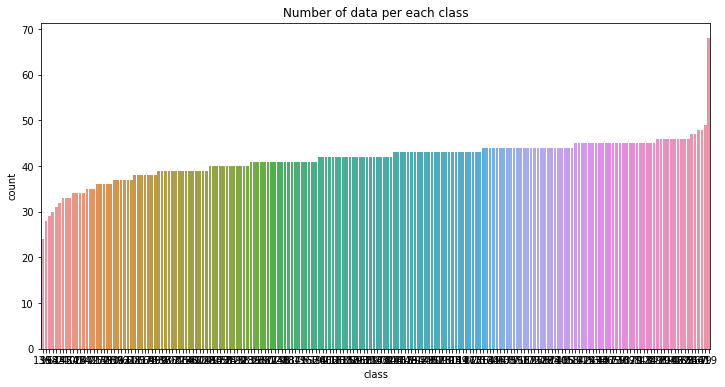

In [15]:
## 클래스 분포 확인

plt.figure(figsize=(12, 6))
sns.countplot(df_train["class"], order=df_train["class"].value_counts(ascending=True).index)
plt.title("Number of data per each class")
plt.show()

## 이미지 확인

In [17]:
import PIL
from PIL import ImageDraw

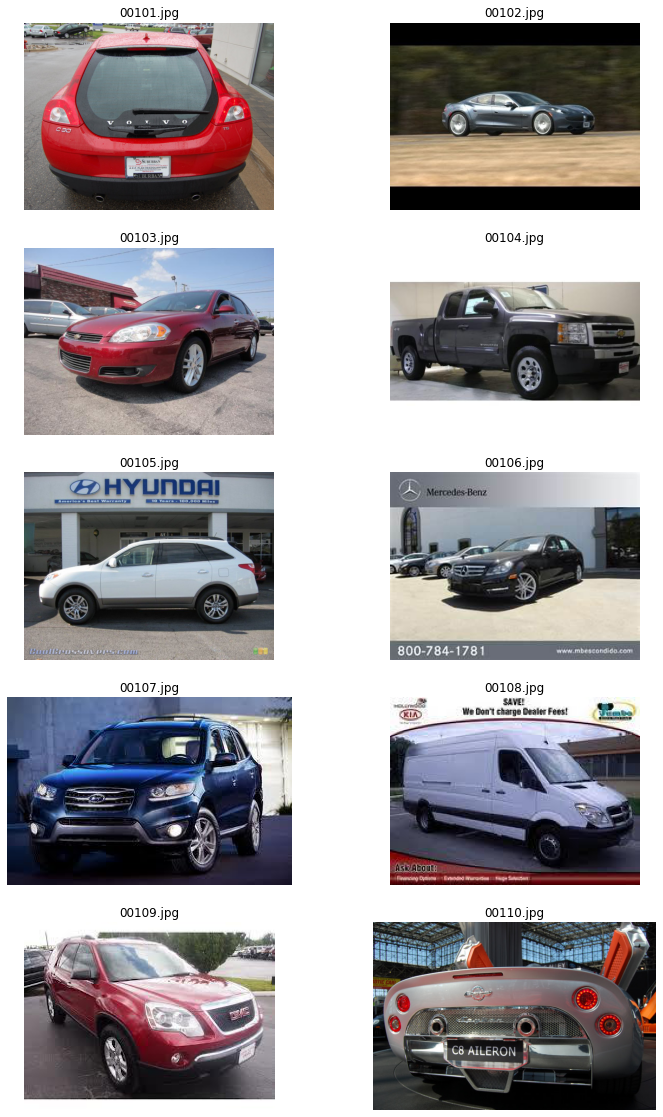

In [18]:
tmp_imgs = df_train['img_file'][100:110]
plt.figure(figsize=(12,20))

for num, f_name in enumerate(tmp_imgs):
    img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
    plt.subplot(5, 2, num + 1)
    plt.title(f_name)
    plt.imshow(img)
    plt.axis('off')

In [19]:
## 박스 처리

def draw_rect(drawcontext, pos, outline=None, width=0):
    (x1, y1) = (pos[0], pos[1])
    (x2, y2) = (pos[2], pos[3])
    points = (x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)
    drawcontext.line(points, fill=outline, width=width)

In [20]:
## train data 바운딩 처리

def make_boxing_img_train(img_name) :
    PATH = TRAIN_IMG_PATH
    data = df_train

    img = PIL.Image.open(os.path.join(PATH, img_name))
    pos = data.loc[data["img_file"] == img_name, \
                   ['bbox_x1','bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)
    draw = ImageDraw.Draw(img)
    draw_rect(draw, pos, outline='red', width=10)
    
    return img

In [21]:
## test data 바운딩 처리

def make_boxing_img_test(img_name) :
    PATH = TEST_IMG_PATH
    data = df_train

    img = PIL.Image.open(os.path.join(PATH, img_name))
    pos = data.loc[data["img_file"] == img_name, \
                   ['bbox_x1','bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)
    draw = ImageDraw.Draw(img)
    draw_rect(draw, pos, outline='red', width=10)
    
    return img

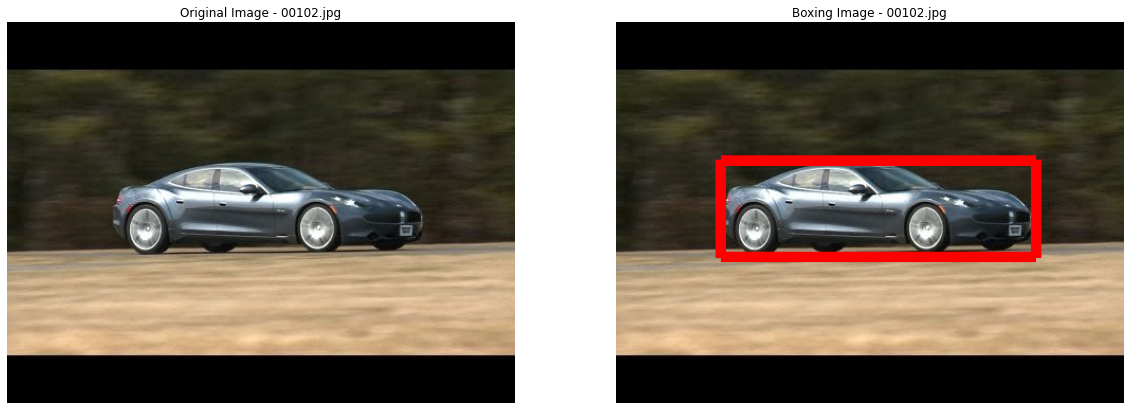

In [27]:
## 확인하고 싶은 이미지 번호 입력
f_name = "00102.jpg"

plt.figure(figsize=(20,10))

## 원본 이미지
plt.subplot(1, 2, 1)
origin_img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
plt.title("Original Image - {}".format(f_name))
plt.imshow(origin_img)
plt.axis('off')

## Bounding Box 처리 된 이미지
plt.subplot(1, 2, 2)
boxing = make_boxing_img_train(f_name)
plt.title("Boxing Image - {}".format(f_name))
plt.imshow(boxing)
plt.axis('off')

plt.show()

## 이미지 resize 하기

In [28]:
## train 이미지 resize

def crop_resize_boxing_img_train(img_name, margin=16, size=(224, 224)) :
    PATH = TRAIN_IMG_PATH
    data = df_train
        
    img = PIL.Image.open(os.path.join(PATH, img_name))
    pos = data.loc[data["img_file"] == img_name, \
                   ['bbox_x1','bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)

    width, height = img.size
    x1 = max(0, pos[0] - margin)
    y1 = max(0, pos[1] - margin)
    x2 = min(pos[2] + margin, width)
    y2 = min(pos[3] + margin, height)

    return img.crop((x1,y1,x2,y2)).resize(size)

In [29]:
## test 이미지 resize

def crop_resize_boxing_img_test(img_name, margin=16, size=(224, 224)) :
    PATH = TEST_IMG_PATH
    data = df_test
        
    img = PIL.Image.open(os.path.join(PATH, img_name))
    pos = data.loc[data["img_file"] == img_name, \
                   ['bbox_x1','bbox_y1', 'bbox_x2', 'bbox_y2']].values.reshape(-1)

    width, height = img.size
    x1 = max(0, pos[0] - margin)
    y1 = max(0, pos[1] - margin)
    x2 = min(pos[2] + margin, width)
    y2 = min(pos[3] + margin, height)

    return img.crop((x1,y1,x2,y2)).resize(size)

## 리사이즈 후 저장

In [61]:
# %%time
# ## 박스에 맞춰 이미지 resize (train data) 후 폴더에 저장

# for i, row in df_test.iterrows():
#     cropped = crop_resize_boxing_img_train(row['img_file'])
#     cropped.save(f"{'/content/drive/My Drive/Colab Notebooks/Stanford Cars Dataset/car_data/car_data/train_crop'}/{row['img_file']}")

In [62]:
# %%time
# ## 박스에 맞춰 이미지 resize (test data) 후 폴더에 저장

# for i, row in df_test.iterrows():
#     cropped = crop_resize_boxing_img_test(row['img_file'])
#     cropped.save(f"{'/content/drive/My Drive/Colab Notebooks/Stanford Cars Dataset/car_data/car_data/test_crop'}/{row['img_file']}")

In [60]:
## crop 이미지 경로 설정

TRAIN_CROP_PATH = os.path.join(DATA_PATH, 'train_crop')
TEST_CROP_PATH = os.path.join(DATA_PATH, 'test_crop')

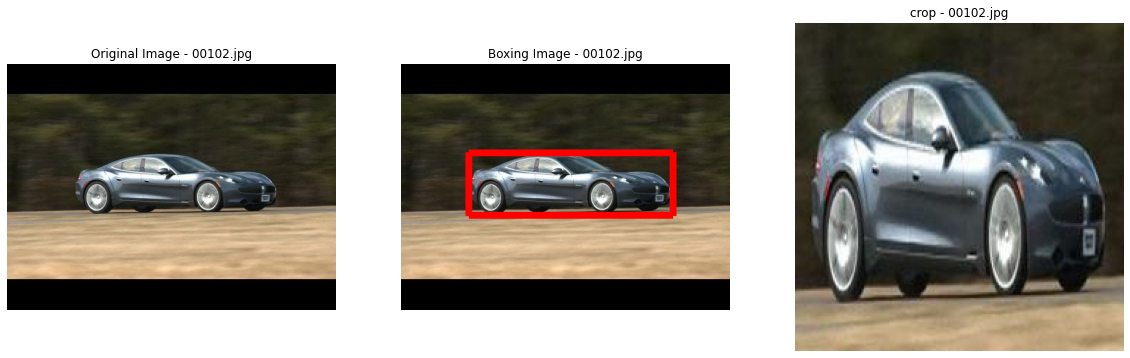

In [63]:
## 확인하고 싶은 이미지 번호 입력
f_name = "00102.jpg"

plt.figure(figsize=(20,10))

## 원본 이미지
plt.subplot(1, 3, 1)
origin_img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
plt.title("Original Image - {}".format(f_name))
plt.imshow(origin_img)
plt.axis('off')

## Bounding Box 처리 된 이미지
plt.subplot(1, 3, 2)
boxing = make_boxing_img_train(f_name)
plt.title("Boxing Image - {}".format(f_name))
plt.imshow(boxing)
plt.axis('off')

## crop 된 이미지
plt.subplot(1, 3, 3)
crop = PIL.Image.open(os.path.join(TRAIN_CROP_PATH, f_name))
plt.title("crop - {}".format(f_name))
plt.imshow(crop)
plt.axis('off')

plt.show()

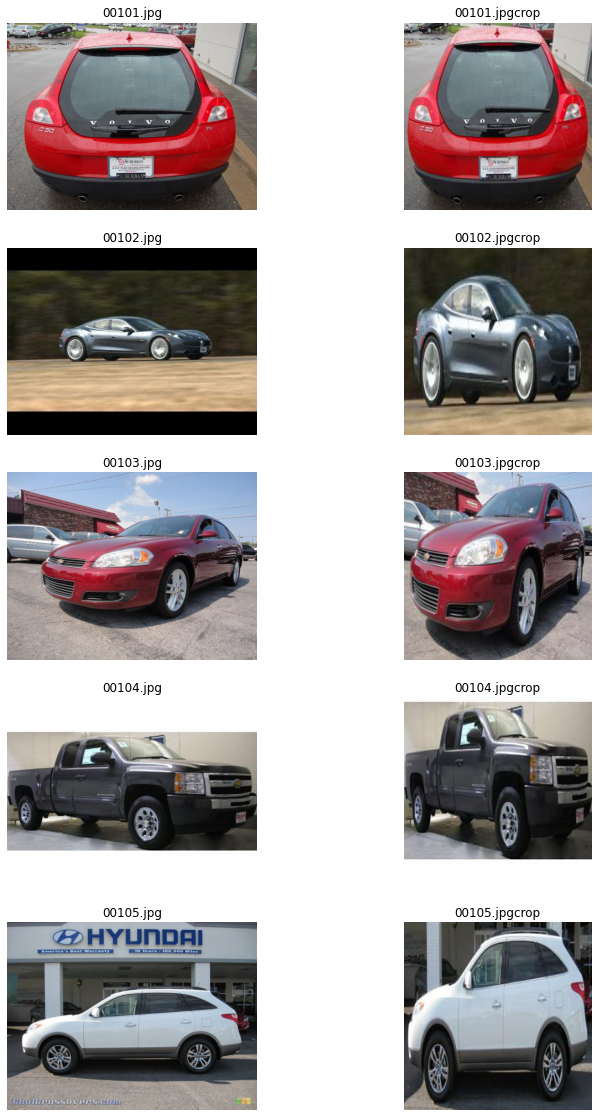

In [64]:
## crop 된 이미지 확인

tmp_imgs = df_train['img_file'][100:105]
plt.figure(figsize=(12,20))

for num, f_name in enumerate(tmp_imgs):
    img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
    plt.subplot(5, 2, 2*num + 1)
    plt.title(f_name)
    plt.imshow(img)
    plt.axis('off')
    
    img = PIL.Image.open(os.path.join(TRAIN_CROP_PATH, f_name))
    plt.subplot(5, 2, 2*num + 2)
    plt.title(f_name + "crop")
    plt.imshow(img)
    plt.axis('off')

## 모델링

In [65]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8144 entries, 0 to 8143
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   img_file  8144 non-null   object
 1   bbox_x1   8144 non-null   int64 
 2   bbox_y1   8144 non-null   int64 
 3   bbox_x2   8144 non-null   int64 
 4   bbox_y2   8144 non-null   int64 
 5   class     8144 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 381.9+ KB


In [66]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8041 entries, 0 to 8040
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   img_file  8041 non-null   object
 1   bbox_x1   8041 non-null   int64 
 2   bbox_y1   8041 non-null   int64 
 3   bbox_x2   8041 non-null   int64 
 4   bbox_y2   8041 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 314.2+ KB


In [67]:
## train, val, test set 나눠주기

from sklearn.model_selection import train_test_split

## class 를 string 으로 바꿔주고 좌표들을 지워준다.
df_train["class"] = df_train["class"].astype('str')

df_train = df_train[['img_file', 'class']]
df_test = df_test[['img_file']]

its = np.arange(df_train.shape[0])
train_idx, val_idx = train_test_split(its, train_size = 0.8, random_state=42)

X_train = df_train.iloc[train_idx, :]
X_val = df_train.iloc[val_idx, :]

print(X_train.shape)
print(X_val.shape)
print(df_test.shape)

(6515, 2)
(1629, 2)
(8041, 1)


모델링은 keras의 generator 들을 이용하면 쉽게 만들 수 있다.

In [69]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [70]:
## 데이터 제네레이터 구성하기

## 파라미터 설정
## https://keras.io/api/preprocessing/image/

img_size = (224, 224)
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
nb_test_samples = len(df_test)
epochs = 20
batch_size = 32

## 입력이미지의 데이터 증강 (Data Augmentation)
train_datagen = ImageDataGenerator(
#     horizontal_flip = True, 
#     vertical_flip = False,
#     preprocessing_function=preprocess_input
    preprocessing_function=preprocess_input,
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Make Generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train, 
    directory=TRAIN_CROP_PATH,
    x_col = 'img_file',
    y_col = 'class',
    target_size = img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    seed=42
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=X_val, 
    directory=TRAIN_CROP_PATH,
    x_col='img_file',
    y_col='class',
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=TEST_CROP_PATH,
    x_col='img_file',
    y_col=None,
    target_size= img_size,
    color_mode='rgb',
    class_mode=None,
    batch_size=batch_size,
    shuffle=False
)

Found 6515 validated image filenames belonging to 196 classes.
Found 1629 validated image filenames belonging to 196 classes.
Found 8041 validated image filenames.


In [71]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, GlobalAveragePooling2D

In [72]:
# for layer in resNet_model.layers:
#     layer.trainable = False
#     print(layer,layer.trainable)

mobileNetModel = MobileNet(weights='imagenet', include_top=False)

model = Sequential()
model.add(mobileNetModel)
model.add(GlobalAveragePooling2D())
model.add(Dense(196, activation='softmax', kernel_initializer='he_normal'))
model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, None, None, 1024)  3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 196)               200900    
Total params: 3,429,764
Trainable params: 3,407,876
Non-trainable params: 21,888
_________________________________________________________________


In [73]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [74]:
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0 :
        return (num_samples // batch_size) + 1
    else :
        return num_samples // batch_size

In [75]:
%%time

model.fit_generator(
    train_generator,
    steps_per_epoch = get_steps(nb_train_samples, batch_size),
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = get_steps(nb_validation_samples, batch_size)
)


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
204/204 [==============================] - 143s 613ms/step - loss: 3.9838 - acc: 0.1747 - val_loss: 4.7766 - val_acc: 0.1013
Epoch 2/20
204/204 [==============================] - 89s 436ms/step - loss: 1.5901 - acc: 0.5834 - val_loss: 2.4370 - val_acc: 0.4248
Epoch 3/20
204/204 [==============================] - 89s 434ms/step - loss: 0.8842 - acc: 0.7509 - val_loss: 1.4106 - val_acc: 0.6212
Epoch 4/20
204/204 [==============================] - 89s 435ms/step - loss: 0.5666 - acc: 0.8393 - val_loss: 1.6850 - val_acc: 0.5666
Epoch 5/20
204/204 [==============================] - 89s 435ms/step - loss: 0.4366 - acc: 0.8717 - val_loss: 1.3673 - val_acc: 0.6544
Epoch 6/20
204/204 [==============================] - 89s 437ms/step - loss: 0.3426 - acc: 0.8981 - val_loss: 1.4530 - val_acc: 0.6243
Epoch 7/20
204/204 [==============================] - 89s 434ms/step - loss: 0.3063 - acc: 0.9085 - val_loss: 1.1726 - val_acc: 0.6869
Epoch 8/20
204/204 [==============================] - 

바운딩박스 실습을 위해 직접 자신을 찍을 사진을 골라 - 바운딩 박스를 긋고 모델에 넣고 분류를 해 보았다. (국내 현대)